# Dog breed classification with Sift 

#### Libraries

In [213]:
import itertools
from keras.utils import np_utils
from glob import glob
import os
from sklearn.datasets import load_files 
from lxml import etree 
import random
from shutil import copyfile

#Image 
import numpy as np
import pandas as pd
import progressbar


from PIL import Image
import cv2

#Ploting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
%matplotlib inline


#Model selection
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

#Models
from sklearn.svm import SVC

#Visualization
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

#### Constants

In [232]:
RANDOM_STATE = 42

IMAGE = '../data/images/n02091467-Norwegian_elkhound/n02091467_2663.jpg'
DEFAULT_IMAGE_1 = '../data/processed_images/n02091467-Norwegian_elkhound/n02091467_2663.jpg'
DEFAULT_IMAGE_2 = '../data/processed_train_test/train/n02111889-Samoyed/1.jpg'
IMG_PATH = '../data/images/'


#Dataset params
IMAGE_SIZE = (256, 256)
SIZE = 256

#SIFT params
COMPUTE_DICTIONNARY = False
COMPUTE_FEATURES_BOW = False
DICTIONNARY_SIZE = 512

## I. Datas

#### Images repartition 

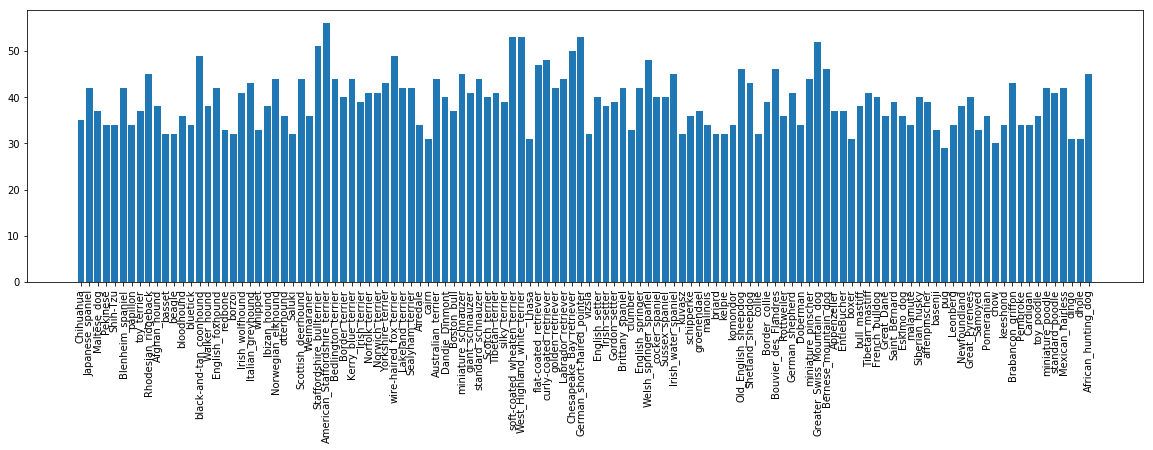

In [236]:
list_names = []
num_files = []

for  folder in sorted(glob("../data/images/*/")):
    list_names.append(folder[25:-1])
    num_files.append(len(folder))    

plt.figure(figsize=(20,5))
plt.xticks(rotation=90)
plt.bar(list_names,num_files)
plt.show()

### I.1. Preprocessing

In [20]:
def resize(img):
    """
    Resize image to a square of fixed size
    """
    # old_size is in (height, width) format
    old_size = img.shape[:2] 

    ratio = float(SIZE)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format
    img = cv2.resize(img, (new_size[1], new_size[0]))
    
    # adding black padding when original image is smaller than the dezired size
    delta_w = SIZE - new_size[1]
    delta_h = SIZE - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    
    new_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    
    return new_img

#### Creating new folders for processed images

In [21]:
if not os.path.exists('../data/processed_images'):
    for r, d, f in os.walk(img_path):
        dirs = r.split(os.path.sep)[-1]
        processed_path = os.path.join('../data', 'processed_images', dirs) 
        os.mkdir(processed_path)

#### Processing images

For my algorithm to work better, I first need to process images.
The first thing is to center images on dogs only, then apply filter to enlight the features and finally resize all images to (256,256,3).

In [23]:
for r, d, f in os.walk(IMG_PATH):
    for file in f:
        ### Annotation information
        # associated annotation path
        path = os.path.join(r, file)[15:-4]
        annotation = os.path.join('../data', 'Annotation', path)
        # dictionnary of coordinates to crop the image to the dog part
        tree = etree.parse(annotation)
        for x in tree.xpath('./object/bndbox'):
            l = x.getchildren()
            dim = {'xmin':int(l[0].text), 'ymin':int(l[1].text), 
                   'xmax':int(l[2].text), 'ymax':int(l[3].text)}
        # breed 
        for x in tree.xpath('./object/name'):
            breed = x.text
        
        ### Processing
        image = cv2.imread(os.path.join(r, file))  
        # get dimension 
        xmin = dim['xmin']
        xmax = dim['xmax']
        ymin = dim['ymin']
        ymax = dim['ymax']
        # cropping
        img_crop = image[ymin:ymax, xmin:xmax]
        # resizing
        img_resize = resize(img_crop)
        # histogram equalization
        img_yuv = cv2.cvtColor(img_resize, cv2.COLOR_BGR2YUV)
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
        img_equal = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
        # gaussian filter 
        img_gaussian = cv2.GaussianBlur(img_equal, (9, 9),0)
        # saving processed images
        img = img_gaussian.copy()
        new_path = os.path.join('../data','processed_images',path +'.jpg')
        cv2.imwrite(new_path, img)      

#### Example

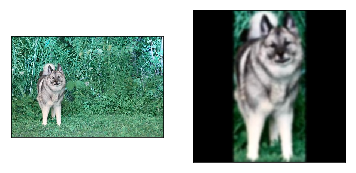

In [233]:
img= cv2.imread(IMAGE)
img_processed = cv2.imread(DEFAULT_IMAGE_1)

plt.subplot(121)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.imshow(img_processed)
plt.xticks([])
plt.yticks([])
plt.show()


### I.2. Split train test

In [24]:
def img_train_test_split(img_source_dir, train_size, validation_size):
    """
    Randomly splits images over a train and validation folder, while preserving the folder structure
    
    Parameters
    ----------
    img_source_dir : string
        Path to the folder with the images to be split. Can be absolute or relative path   
        
    train_size : float
        Proportion of the original images that need to be copied in the subdirectory in the train folder
    """    
    if not (isinstance(img_source_dir, str)):
        raise AttributeError('img_source_dir must be a string')
        
    if not os.path.exists(img_source_dir):
        raise OSError('img_source_dir does not exist')
        
    if not (isinstance(train_size, float)):
        raise AttributeError('train_size must be a float')
        
    # Set up empty folder structure if not exists
    if not os.path.exists('../data'):
        os.makedirs('../data')
    else:
        if not os.path.exists('../data/processed_train_test/train'):
            os.makedirs('../data/processed_train_test/train')
        if not os.path.exists('../data/processed_train_test/validation'):
            os.makedirs('../data/processed_train_test/validation')
        if not os.path.exists('../data/processed_train_test/test'):
            os.makedirs('../data/processed_train_test/test')
            
    # Get the subdirectories in the main image folder
    subdirs = [subdir for subdir in os.listdir(img_source_dir) if os.path.isdir(os.path.join(img_source_dir, subdir))]

    for subdir in subdirs:
        subdir_fullpath = os.path.join(img_source_dir, subdir)
        if len(os.listdir(subdir_fullpath)) == 0:
            print(subdir_fullpath + ' is empty')
            break

        train_subdir = os.path.join('../data/processed_train_test/train', subdir)
        validation_subdir = os.path.join('../data/processed_train_test/validation', subdir)
        test_subdir = os.path.join('../data/processed_train_test/test', subdir)

        # Create subdirectories in train and validation folders
        if not os.path.exists(train_subdir):
            os.makedirs(train_subdir)

        if not os.path.exists(validation_subdir):
            os.makedirs(validation_subdir)
            
        if not os.path.exists(test_subdir):
            os.makedirs(test_subdir)

        train_counter = 0
        validation_counter = 0
        test_counter = 0

        # Randomly assign an image to train or validation folder
        for filename in os.listdir(subdir_fullpath):
            if filename.endswith(".jpg") or filename.endswith(".png"): 
                fileparts = filename.split('.')

                if random.uniform(0, 1) <= train_size:
                    copyfile(os.path.join(subdir_fullpath, filename),
                             os.path.join(train_subdir, str(train_counter) + '.' + fileparts[1]))
                    train_counter += 1
                elif random.uniform(0, 1) <= validation_size:
                    copyfile(os.path.join(subdir_fullpath, filename),
                             os.path.join(validation_subdir, str(validation_counter) + '.' + fileparts[1]))
                    validation_counter += 1
                else :
                    copyfile(os.path.join(subdir_fullpath, filename),
                             os.path.join(test_subdir, str(test_counter) + '.' + fileparts[1]))
                    test_counter += 1
                    

In [25]:
img_train_test_split('../data/processed_images/', 0.7, 0.7)

### I.3. Load datasets

In [26]:
def load_images(img_path):
    """
    Load images and labels
    
    Parameters
    ----------
    path : string
        Path to folder
    """
    images = []
    labels = []
    for breed in os.listdir(img_path):
        label = breed[10:].lower()
        path = img_path + "/" + breed
        
        for dogs in os.listdir(path):
            img = cv2.imread(path + "/" + dogs)
            img = resize(img)
            if img is not None:
                images.append(np.array(img))
                labels.append(label)
                
    images = np.stack(images)
    labels = np.stack(labels)
    return images, labels

In [27]:
X_train, y_train = load_images('../data/processed_train_test/train')  
X_valid, y_valid = load_images('../data/processed_train_test/validation') 
X_test, y_test = load_images('../data/processed_train_test/test')

#### Save the datasets to files

In [28]:
np.save('../data/datasets/' + 'X_train', X_train)
np.save('../data/datasets/' + 'X_valid', X_valid)
np.save('../data/datasets/' + 'y_train', y_train)
np.save('../data/datasets/' + 'y_valid', y_valid)
np.save('../data/datasets/' + 'X_test', X_test)
np.save('../data/datasets/' + 'y_test', y_test)

## II. Sift

In [29]:
sift = cv2.xfeatures2d.SIFT_create()

### II.1. Example

Here are what our SIFT features look like :


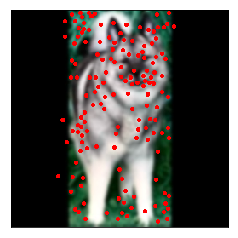

In [235]:
kp, desc = sift.detectAndCompute(img_processed, None)

#plt.imshow(cv2.drawKeypoints(img_example, kp, color_img.copy()))
#drawkeypoints doesn't work with WSL

img = img_processed.copy()
for marker in kp:
    img = cv2.drawMarker(img, 
                         tuple(int(i) for i in marker.pt),
                         color=(255, 0, 0), markerType=cv2.MARKER_DIAMOND, markerSize=2, thickness=2)
    
print('Here are what our SIFT features look like :')

plt.imshow(img)
plt.xticks([])
plt.yticks([])

plt.show()

### II.2. Build dictionary 

In [40]:
def build_dictionary(data):
    """
    Build a dictionary of bovw
    
    Parameters
    ----------
    data : numpy array
    """
    print('Computing descriptors...')        
    desc_list = []
    bar = progressbar.ProgressBar(maxval=data.shape[0]).start()
                                  
    for idx, img in enumerate(data):        
        kp, desc = sift.detectAndCompute(img, None)
        desc_list.extend(desc)
        bar.update(idx)
        bar.finish()

    dictionary = MiniBatchKMeans(n_clusters=500, batch_size=200, verbose=0, init_size=3*200)
    dictionary.fit(np.array(desc_list))
  
    return dictionary

In [41]:
%time dictionary = build_dictionary(X_train)

100% |########################################################################|


Computing descriptors...


CPU times: user 30min 4s, sys: 19min 23s, total: 49min 27s
Wall time: 19min 8s


### II.3. Features extraction

In [186]:
def feature_extract(data):
    """
    Return list of histograms of image set
    
    Parameters
    ----------
    
    * data : numpy array
    
    * bovw_dict : opencv dictionary
    
    """
    
    histo_list = []

    for i in range(len(data)):
        img=data[i]    
        kp, desc = sift.detectAndCompute(img, None)

        histo = np.zeros(500)
        size_kp = np.size(kp)

        for d in desc:
            idx = dictionary.predict([d])
            histo[idx] += 1/size_kp
        print(histo)
        histo_list.append(histo)
    
    return histo_list

#### Get train & test image features

In [ ]:
train_features = feature_extract(X_train)
val_features = feature_extract(X_val)
test_features = feature_extract(X_test)

## III. Model 

### III.1. Train model

#### SVC

In [206]:
train_features = pd.DataFrame(train_features)
valid_features = pd.DataFrame(valid_features)

In [207]:
c=[1, 5, 10]
gamma=[1, 0.1, 0.01, 0.0001]

param_grid = [{'C': c, 'gamma': gamma, 'kernel': ['rbf']}]

svc = GridSearchCV(SVC(decision_function_shape='ovo'), param_grid, n_jobs=-1, scoring='accuracy', cv=3, iid=False)
svc.fit(train_features, y_train)

train_score = svc.score(train_features, y_train)
test_score = svc.score(valid_features, y_valid)
print('Train score %0.2f:'%train_score)
print('Test score %0.2f:'%test_score)

print('Best params %s' %str(svc.best_params_))


/home/bayet/.virtualenvs/py3cv4/lib/python3.5/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Train score 0.04:
Test score 0.02:
Best params {'C': 10, 'kernel': 'rbf', 'gamma': 1}


### III.2. Scores

In [208]:
#Get accuracy
y_pred = svc.predict(test_feature)
test_score = accuracy_score(y_test, y_pred)
print('Accuracy for test set: %0.2f' %test_score)

Accuracy for test set: 0.02


In [50]:
def plot_confusion_matrix(cm, classes,
                          normalize=False, plot_values=False, printed=False,
                          title='Confusion matrix',
                          figsize=(20,20), cmap=plt.cm.Blues, rotation_xticks=45):
    """
    Prints and Plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    if printed:
        print(cm)

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=rotation_xticks)
    plt.yticks(tick_marks, classes)

    if plot_values:
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            val = format(cm[i, j], fmt)
            val = int(float(val)) if (float(val) >= 1.) else val
            if float(val):
                plt.text(j, i, val,
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix


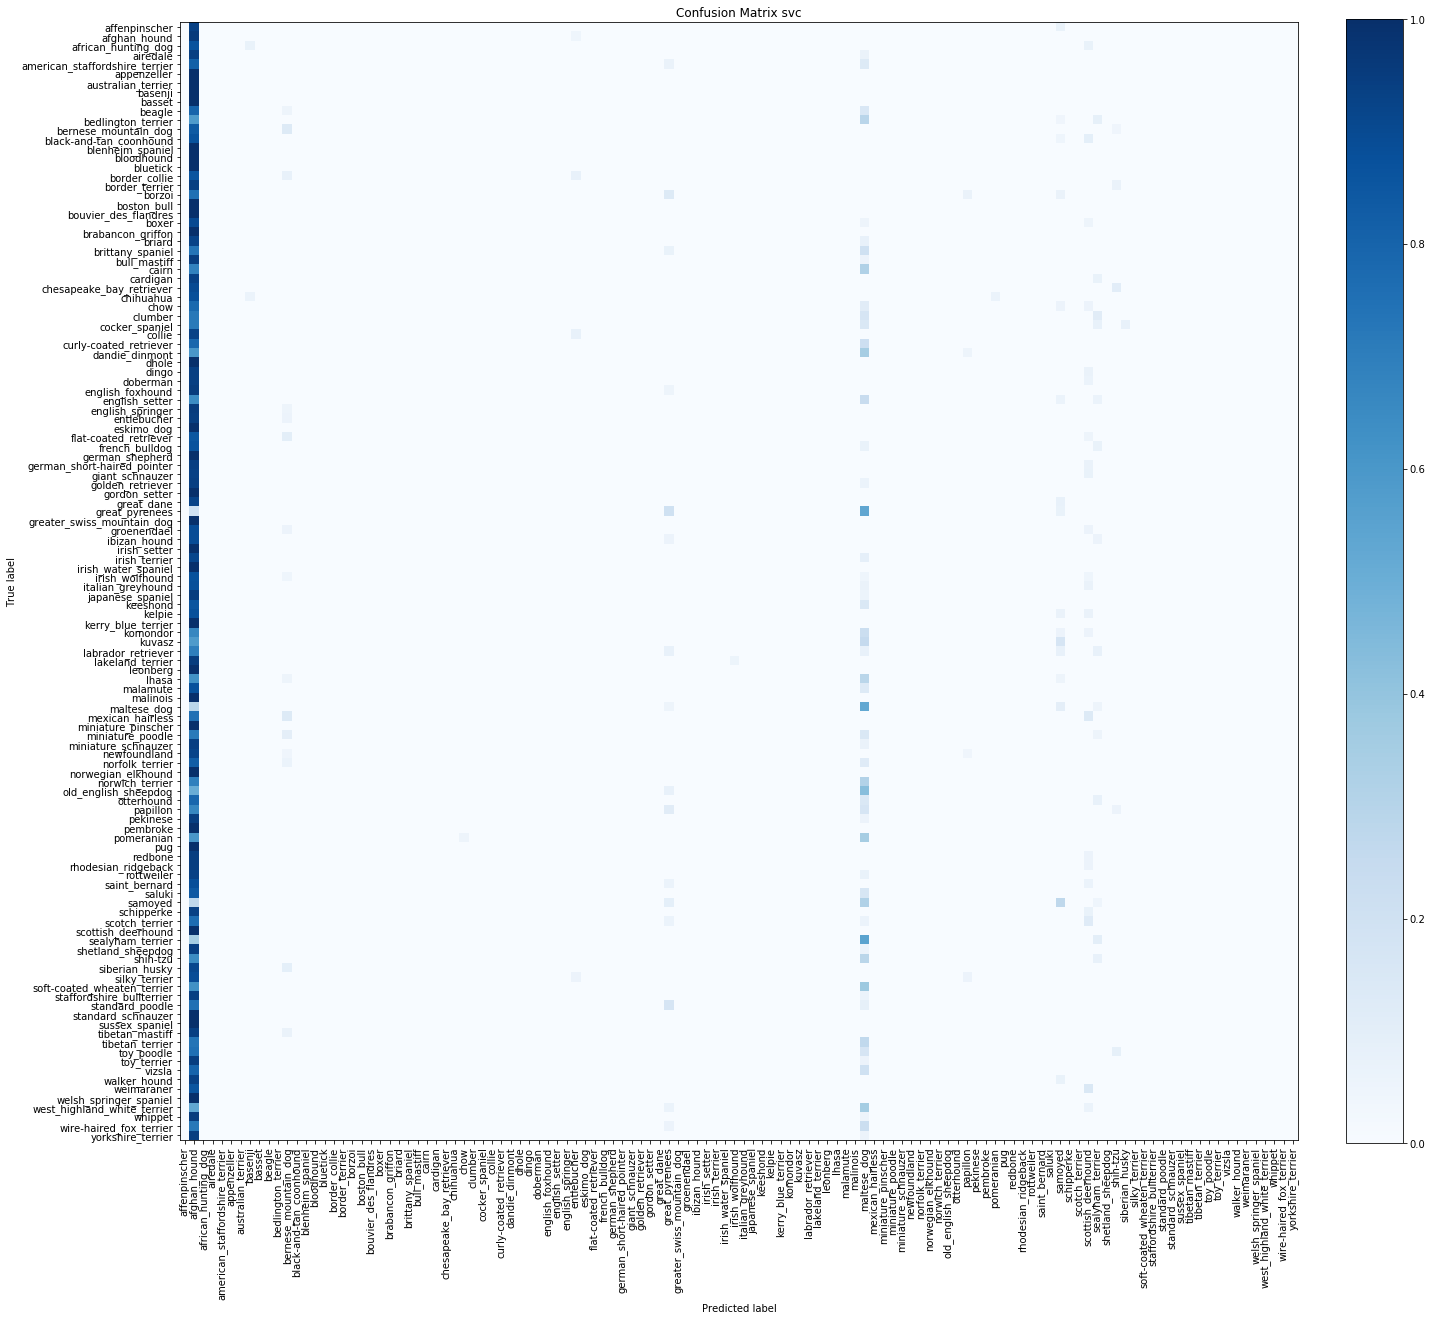

In [212]:
conf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_matrix, classes=np.unique(y_test), \
                      title='Confusion Matrix svc', normalize=True, rotation_xticks=90)